# E-Device Usage Negatively Effects Reading

Hi NMEP Leads, Neurotech NMEP Class of Fall 2020, and anyone else who stumbles upon this notebook. I hope you enjoy whats in store :) 

This notebook reproduces (not authentically, read on) the results of the following journal article (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6681173/). This notebook shows correlations of certain regions of the brain with study participants e-device usage; the results we reproduce are evidence that e-device usage negatively affects reading ability. An in depth analysis as to why our results are evidence that e-device usage negatively affects reading ability can be found at the following link (________).

This notebook was written by Ansh Verma, future Neurotech software member (and thinking about joining the decal team :) )!

Journal Article - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6681173/

fMRI dataset - https://openneuro.org/datasets/ds002247/versions/1.0.0/download

Methods article - https://blclab.org/wp-content/uploads/2019/08/Reading_Brain_Methods_L1Adults.pdf

Folder with all data

In [2]:
!ls '/Users/anshverma/Documents/BerkeleyDocs/Neurotech NMEP Project'

L1_Adults_RBQ.tsv     fMRI func data sub-07 fMRI func data sub-14
fMRI func data sub-01 fMRI func data sub-08 fMRI func data sub-15
fMRI func data sub-02 fMRI func data sub-09 fMRI func data sub-16
fMRI func data sub-03 fMRI func data sub-10 fMRI func data sub-17
fMRI func data sub-04 fMRI func data sub-11 fMRI func data sub-18
fMRI func data sub-05 fMRI func data sub-12 fMRI func data sub-19
fMRI func data sub-06 fMRI func data sub-13 fMRI func data sub-20


In [3]:
file_path_1 = '/Users/anshverma/Documents/BerkeleyDocs/Neurotech NMEP Project'

Generating Electronic Indexs for Participants

In [4]:
files = os.walk(file_path_1)
data = next(files)
data_struct = pd.read_csv(data[0] + "/" + data[2][1], delimiter='\t')
data_collumns = ['9. Reading on eBook devices (5-point scale ranging from [none] to [>5 (hrs)])', 
'9. Reading on computers/laptops (5-point scale ranging from [none] to [>5 (hrs)])', 
'9. Reading on smartphones(5-point scale ranging from [none] to [>5 (hrs)])', 
'10. Time spent texting friends R2',
'10. Time spent playing games online (5-point scale ranging from [none] to [>5 (hrs)])', 
'10. Time spent watching TV (5-point scale ranging from [none] to [>5 (hrs)])', 
]
escore = {}
i = 0

for i in range(1, 53): 
    escore[i] = 0
for collumn in data_collumns:
    i = 0
    for val in data_struct[collumn]:
        i += 1
        if val == None: 
            escore[i] += 0
        elif val == '<2 (hrs)':
            escore[i] += 1
        elif val == '2-3 (hrs)':
            escore[i] += 2
        elif val == '3-5 (hrs)':
            escore[i] += 3
print(escore)

{1: 5, 2: 4, 3: 8, 4: 7, 5: 7, 6: 7, 7: 7, 8: 7, 9: 8, 10: 7, 11: 9, 12: 3, 13: 4, 14: 5, 15: 4, 16: 5, 17: 9, 18: 6, 19: 7, 20: 3, 21: 9, 22: 4, 23: 4, 24: 4, 25: 8, 26: 4, 27: 9, 28: 2, 29: 5, 30: 7, 31: 4, 32: 3, 33: 4, 34: 3, 35: 6, 36: 10, 37: 4, 38: 6, 39: 8, 40: 6, 41: 8, 42: 7, 43: 9, 44: 5, 45: 5, 46: 6, 47: 6, 48: 6, 49: 7, 50: 4, 51: 0, 52: 0}


Loading in Participant Data

In [5]:
file_names = []
data_dict = {}
for folder in files: 
    if folder[0][-5:] != 'AVOID':
        inner_dict = {}
        file_names_inner = []
        for file in folder[2]:
            if '.nii' in file:
                file_names_inner.append(folder[0] + "/" + file)
                inner_dict[file] = [os.path.join(folder[0], file)]
                inner_dict[file].append(nibabel.load(inner_dict[file][0]))
        file_names.append(file_names_inner)
        data_dict[folder[0]] = inner_dict      

# Preprocessing

Generating data array and inverting data

In [6]:
for folder in data_dict:
    folder = data_dict[folder]
    for name in folder:
        folder[name].append(folder[name][-1].get_fdata().T)

Calculating image scanner voxel coordinate points for areas of interest



In [7]:
from nilearn.datasets import load_mni152_template
from nibabel.affines import apply_affine
import numpy.linalg as npl

template = load_mni152_template()
inverse = npl.inv(template.affine)

print(apply_affine(inverse, [27, 20, 18]), "Right Claustrum and one cluser of Left insula and IFG pars triangularis")
print("This position is suppose to show less BOLD peaks as e-index increases")

print(apply_affine(inverse, [-36, -58, 18]), "Left temporoparietal junction")
print("This position is suppose to show increased BOLD peaks as e-index increases")

[31.5 73.  45. ] Right Claustrum and one cluser of Left insula and IFG pars triangularis
This position is suppose to show less BOLD peaks as e-index increases
[63. 34. 45.] Left temporoparietal junction
This position is suppose to show increased BOLD peaks as e-index increases


Note: 

In the cell above I used a template/one-size fits all MNI affine to generate the coordinates that represent brain regions of interest. Technically, every coordinate space should have its own unique mni affine, and using a one-size fits all affine means the brain region of interest coordinate points used throughout this notebook are not completely accurate. 

While this is unfortunate, this is the best I believe I can do right now. After experimenting with the only python package I could find that calculated unique mni affines (pycortex), I decided it would take up too much time to change all the study files to the specific files types and structure they wanted. Also, structuring and converting the data I have to the format pycortex accepted required an understanding of neuroscience and neuroinformatics I do not have yet. 

Therefore, I decided to use a template mni affine; this affine is not completely accurate, but it is suprisingly (and luckily) close :) 

I have provided a proof of concept to its "closeness" below

The below cell is generating a NiftiIMG object transformed into MNI space

This object only has three demensions (no time) as it is only meant to illustrate that 
the data fits into the mni space even though we are using a template mni affine 
(rather than a uniquely generated one!)

In [8]:
from nilearn.image import resample_to_img
mni_image = None
for folder in data_dict:
    folder = data_dict[folder]
    for name in folder:
        mni_image = resample_to_img(folder[name][-2], template)
        temp_data = mni_image.get_fdata().T.mean(axis=0)
        mni_image = nibabel.Nifti1Image(temp_data, mni_image.affine)
        break
    break

/Users/anshverma/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


The following cell makes a NiftiImg object of the original data (in the coordinates 
of the scanner) reduced to three demensions (no time again) 

Then, we visually compare the two arrays of data, seeing if the template mni 
affine actually transposes the data in scanner coordinates to mni coordinates!

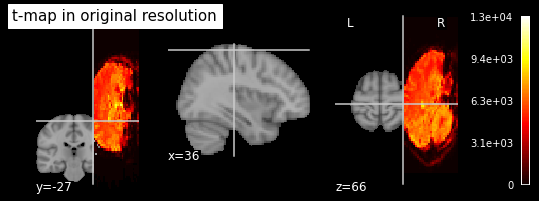

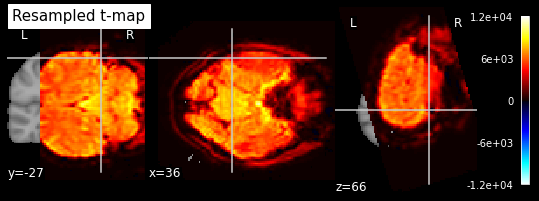

In [9]:
from nilearn.image import load_img

tmap_img = None
for folder in data_dict:
    folder = data_dict[folder]
    for name in folder:
        tmap_img = folder[name][-1].mean(axis=0)
        tmap_img = nibabel.Nifti1Image(tmap_img, folder[name][-2].affine)
        break
    break

from nilearn import plotting

plotting.plot_stat_map(tmap_img,
                       bg_img=template,
                       cut_coords=(36, -27, 66),
                       threshold=3,
                       title="t-map in original resolution")
plotting.plot_stat_map(mni_image,
                       bg_img=template,
                       cut_coords=(36, -27, 66),
                       threshold=3,
                       title="Resampled t-map")
plotting.show()


As we can see, the original scanner data (t-map in original resolution) is completely 
off from the mni space, but the resampled data (resampled t-map) is essentially completely 
transformed to the mni space! Although it isn't perfect, because of time and knowledge constraints this evidence is why I chose to use a template mni affine instead of individualized, completely accurate mni affines. 

Filters to use for getting rid of data noise

Rationale for low pass filter: 


- Choosing to use lowpass filter because it made signal more readable; deviating from paper analysis, therefore did not follow literature for this

- Chose cutoff value of 1/10 through visual inspection; saw that noise in signal was removed without removing overall peaks

- paper stating bold signal amplitude is generally very low (which applying a low pass filter with cutoff value of 1/10 produces) -> https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5102908/

In [10]:
def butter_lowpass_filter(data, fs, cutoff=1/10, order=2):
        """
        function that implements high pass filter on fMRI GSR values
        """
        b, a = butter(order, cutoff, btype='low', analog=False) 
        y = filtfilt(b, a, data)
        return y

Displaying data demensions; read next text block for why

In [11]:
lst = []
for folder in data_dict:
    folder = data_dict[folder]
    for name in folder:
        lst.append(folder[name][-1].shape)
print(lst)

[(554, 30, 80, 80), (493, 30, 80, 80), (511, 30, 80, 80), (477, 30, 80, 80), (487, 30, 80, 80), (564, 30, 80, 80), (562, 30, 80, 80), (667, 30, 80, 80), (648, 30, 80, 80), (565, 30, 80, 80), (732, 30, 80, 80), (467, 30, 80, 80), (468, 30, 80, 80), (502, 30, 80, 80), (556, 30, 80, 80), (445, 30, 80, 80), (396, 30, 80, 80), (489, 30, 80, 80), (493, 30, 80, 80), (406, 30, 80, 80), (499, 30, 80, 80), (508, 30, 80, 80), (566, 30, 80, 80), (504, 30, 80, 80), (539, 30, 80, 80), (656, 30, 80, 80), (611, 30, 80, 80), (657, 30, 80, 80), (700, 30, 80, 80), (645, 30, 80, 80), (894, 30, 80, 80), (662, 30, 80, 80), (919, 30, 80, 80), (747, 30, 80, 80), (697, 30, 80, 80), (524, 30, 80, 80), (568, 30, 80, 80), (496, 30, 80, 80), (562, 30, 80, 80), (640, 30, 80, 80), (679, 30, 80, 80), (675, 30, 80, 80), (750, 30, 80, 80), (715, 30, 80, 80), (690, 30, 80, 80), (679, 30, 80, 80), (566, 30, 80, 80), (545, 30, 80, 80), (702, 30, 80, 80), (641, 30, 80, 80), (658, 30, 80, 80), (601, 30, 80, 80), (652, 30, 8

Below cell filters the BOLD signal at the regions of the brain we are attempting to 
show are either more or less active based on e-score.

You may note that the voxel coordinates I selected to analyze here are not the same coordinates calculated previously. This is because the first dimension of the actually calculated voxel locations is out of range of the demensions of the data from the study. The above cell shows the first demension of the voxel locations that I am working with; the max value I can choose to analyze is 29 (given that 30 is the upper limit), and therefore I cannot input the actual calculated first demension voxel coordinate from the mni affine. 

I think this is likely because I am using a template MNI affine, and therefore the coordinates generated by applying its inverse to the data is not completely accurate. For this reason, I have put the highest first demension I could use for the voxel position later in the pipeline. This is a really wishy-washy thing to do and decreases the validity of our results even more, but unforunately this is all I can do given that I cannot calculate unique MNI affines for each datafile. 

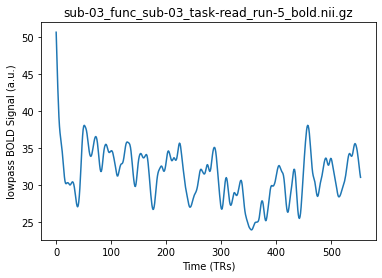

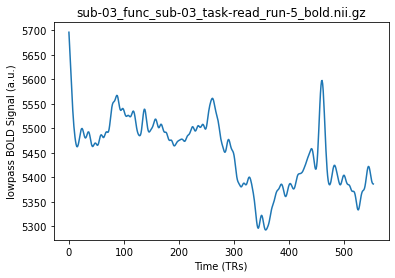

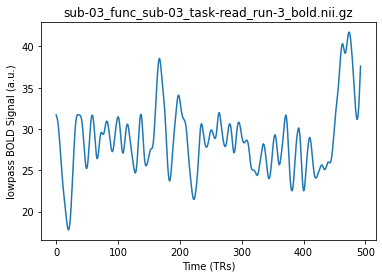

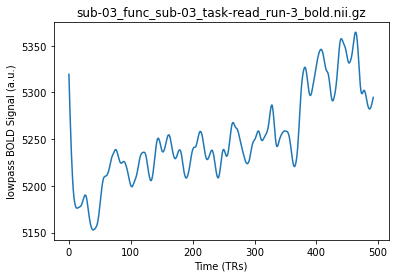

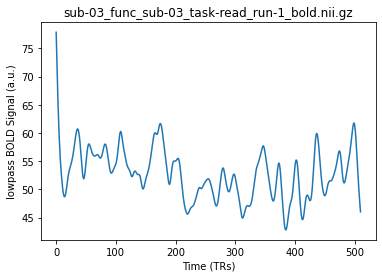

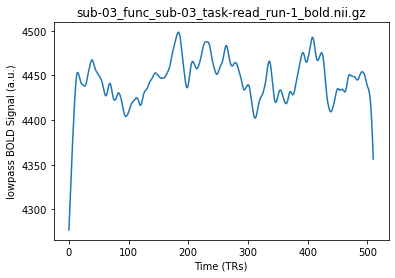

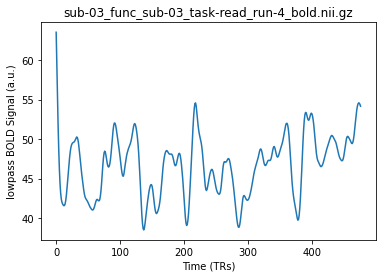

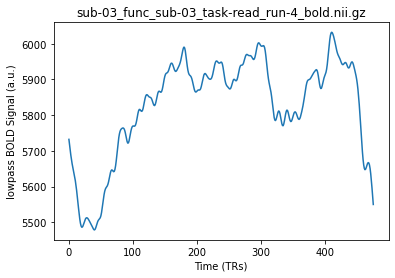

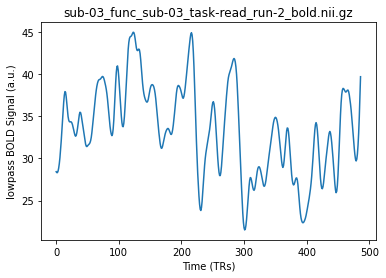

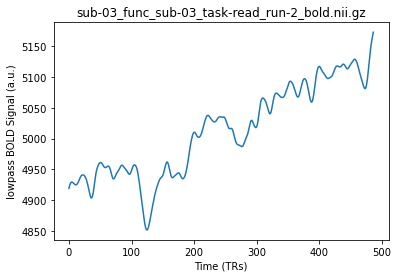

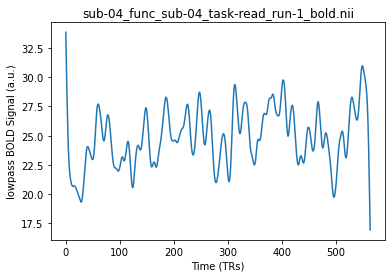

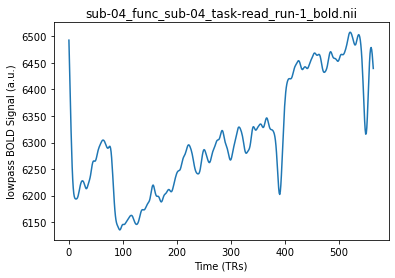

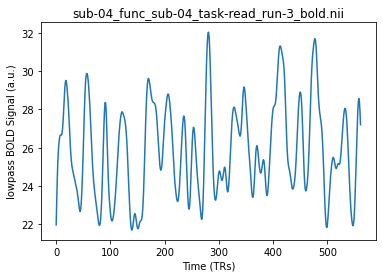

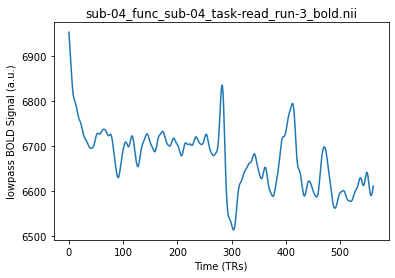

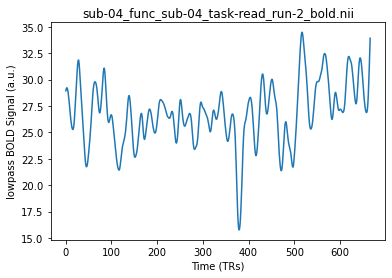

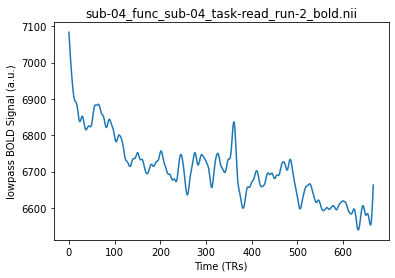

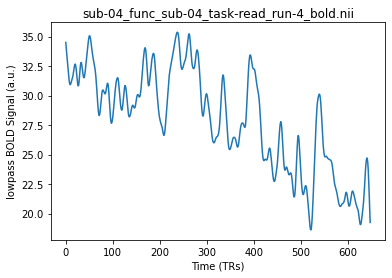

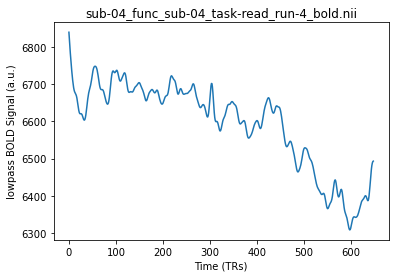

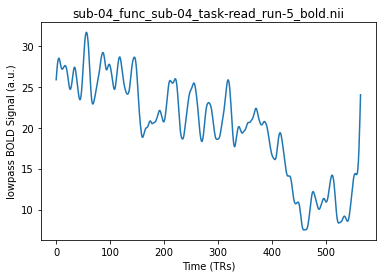

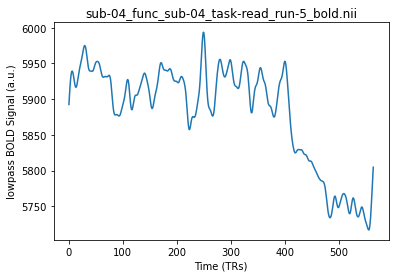

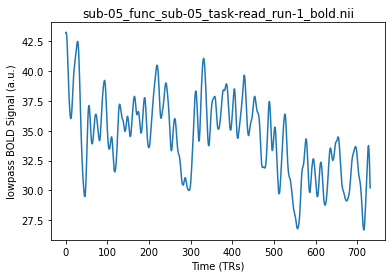

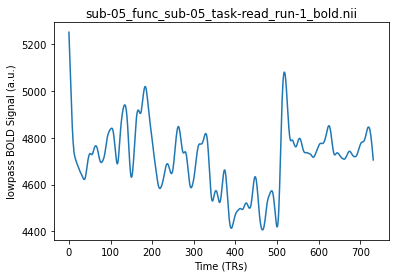

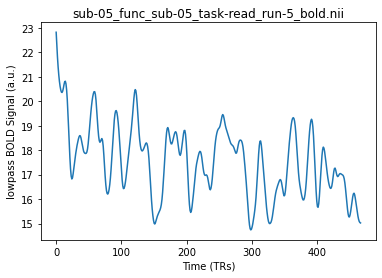

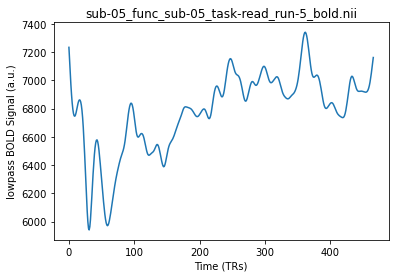

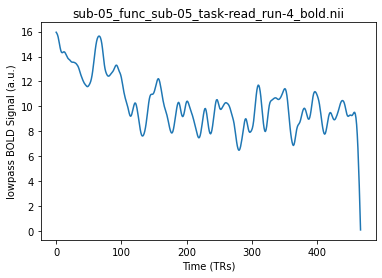

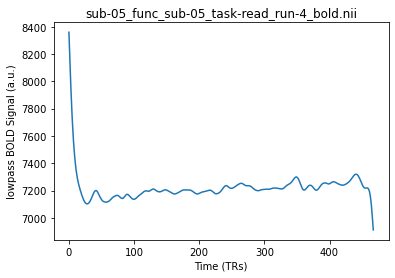

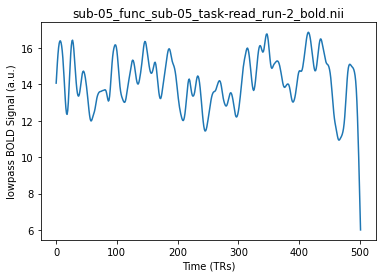

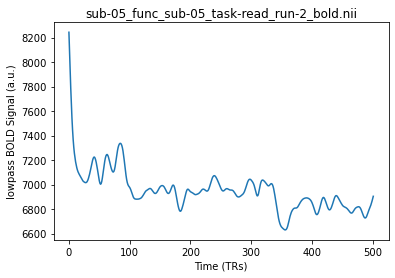

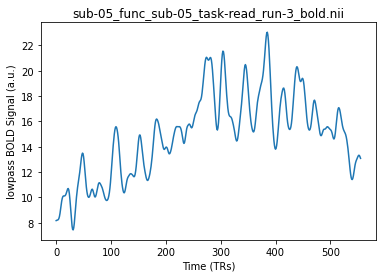

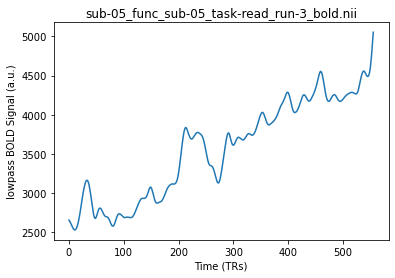

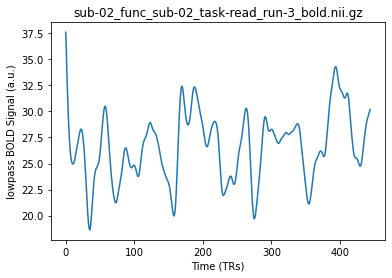

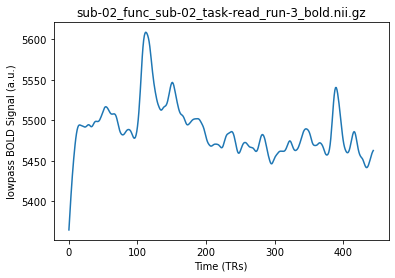

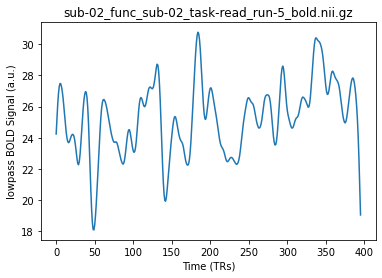

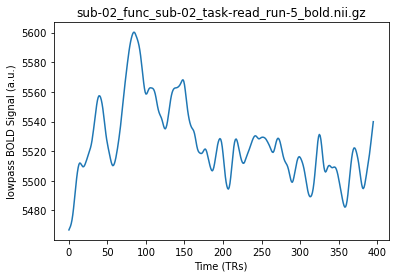

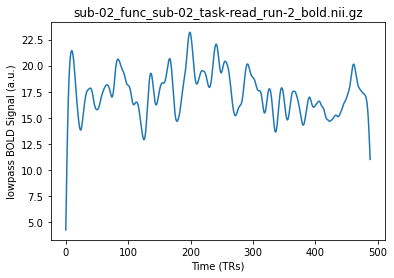

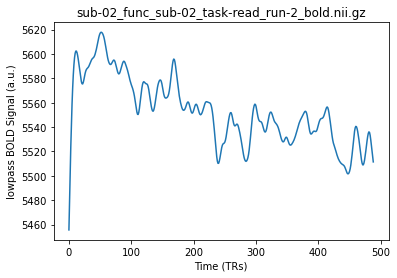

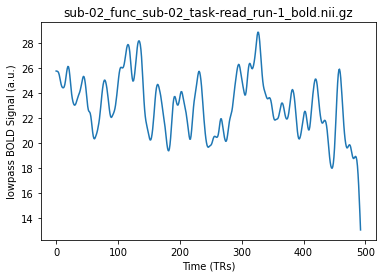

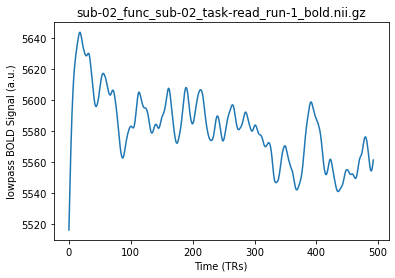

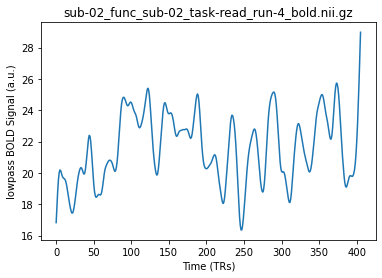

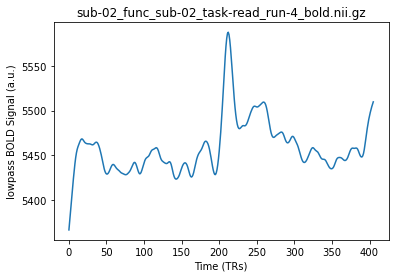

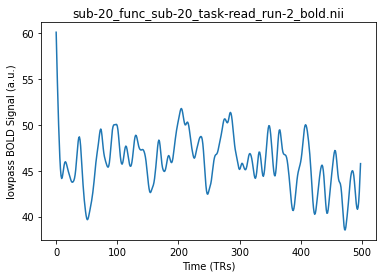

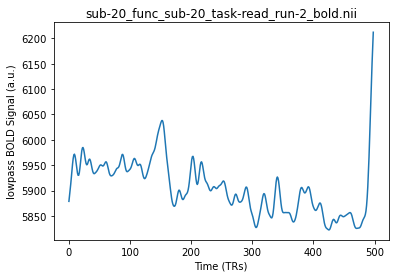

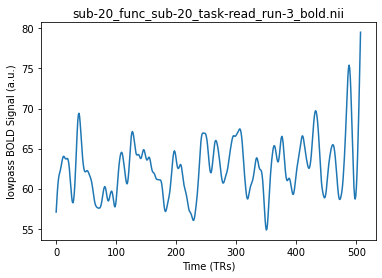

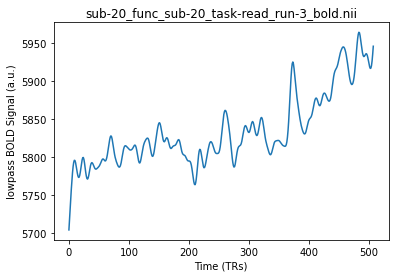

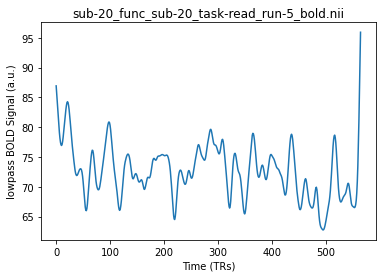

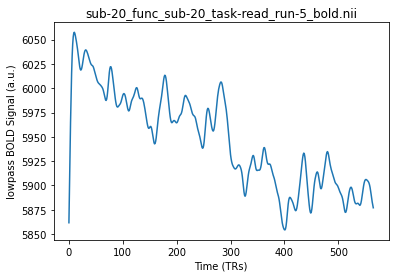

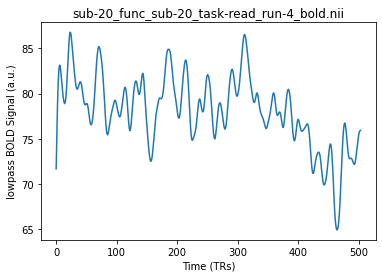

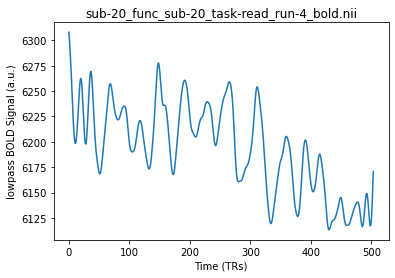

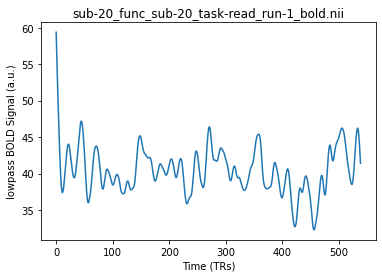

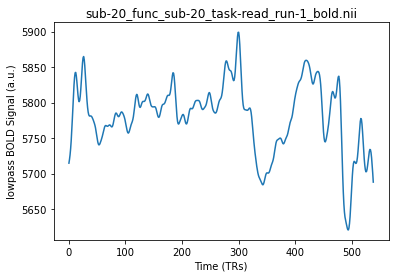

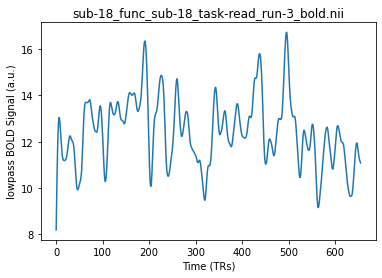

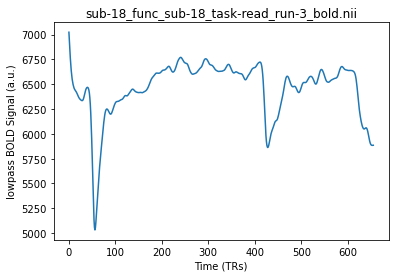

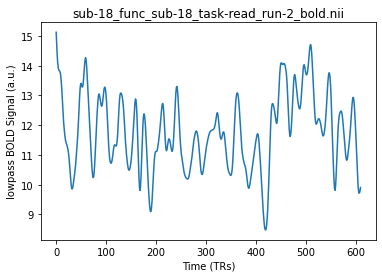

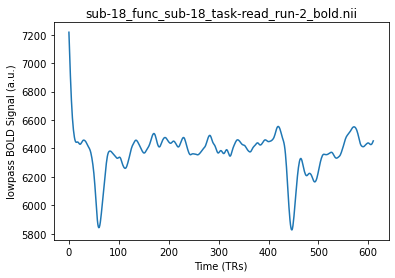

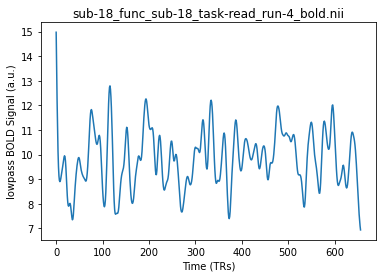

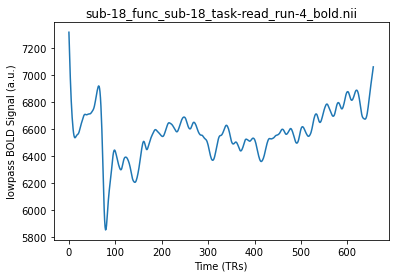

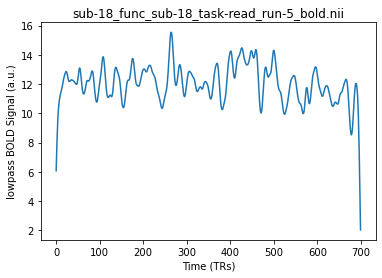

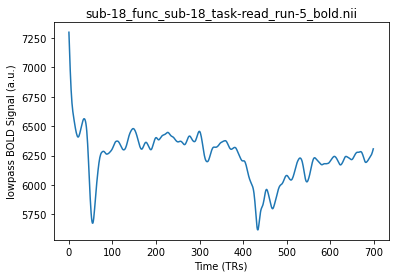

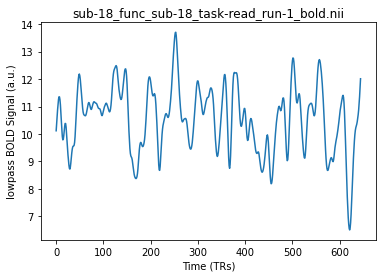

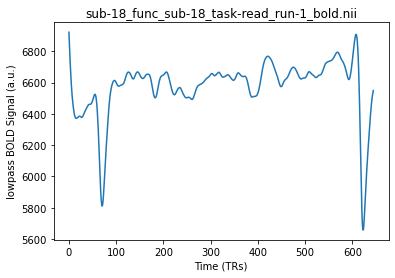

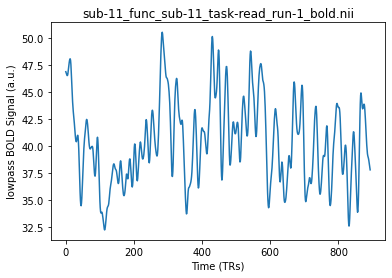

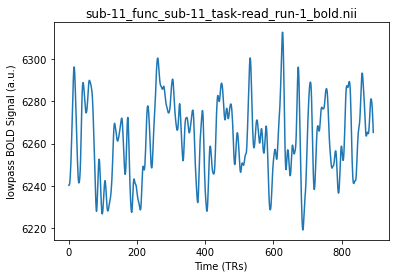

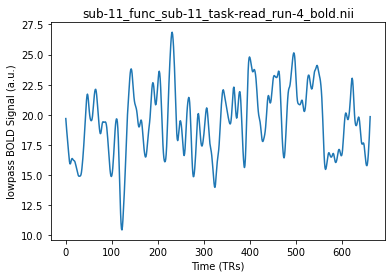

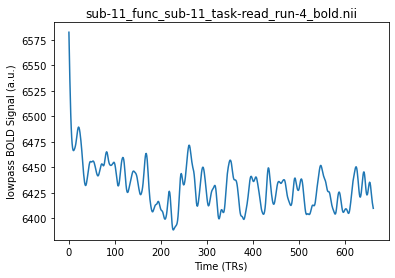

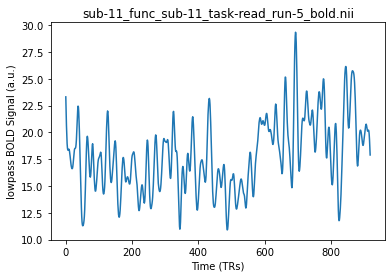

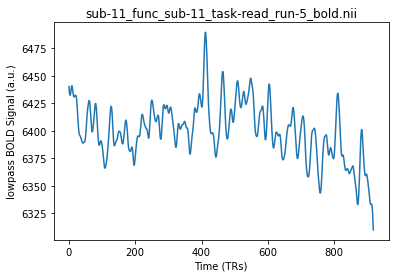

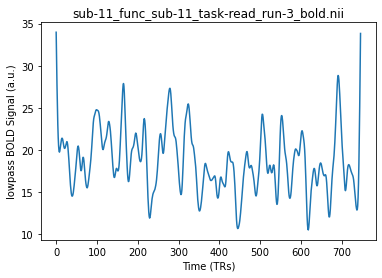

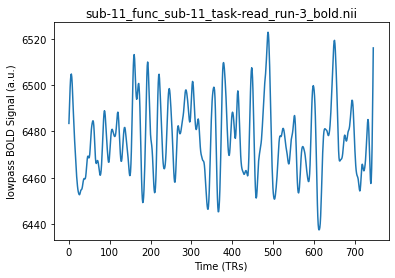

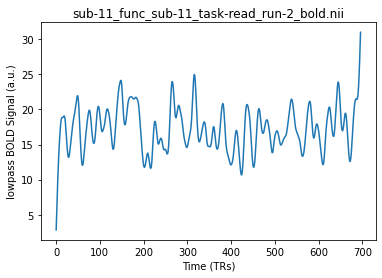

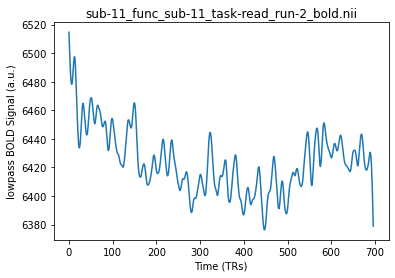

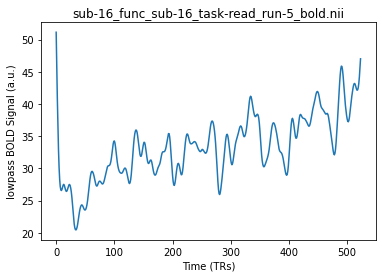

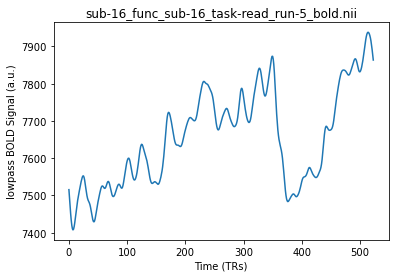

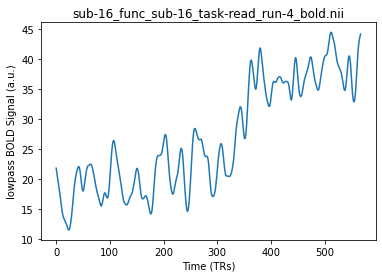

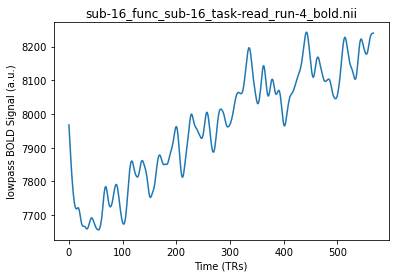

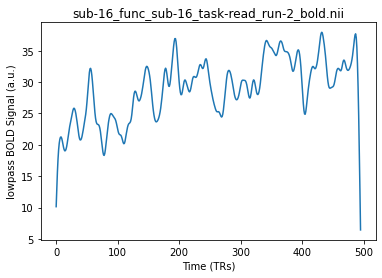

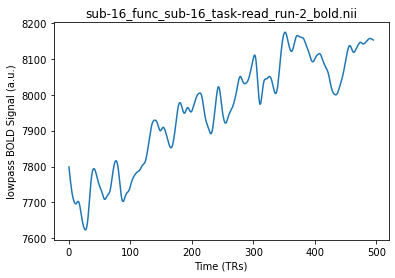

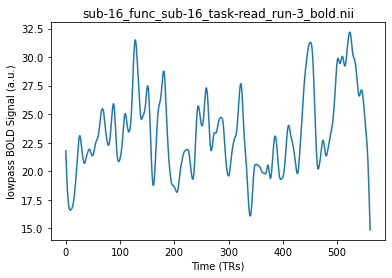

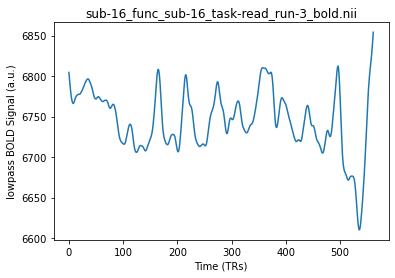

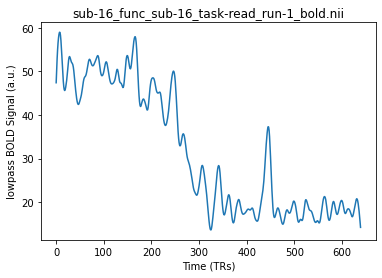

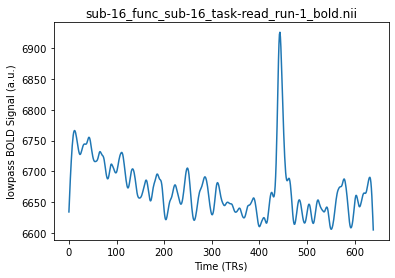

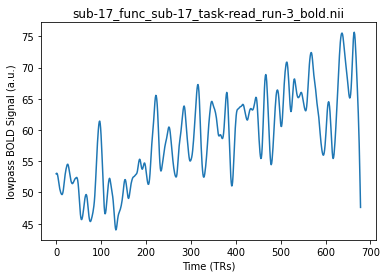

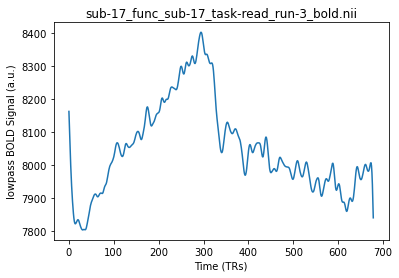

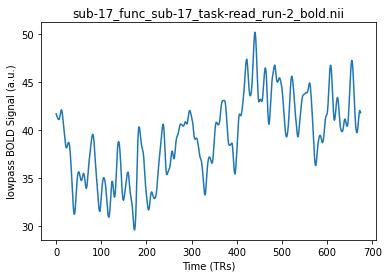

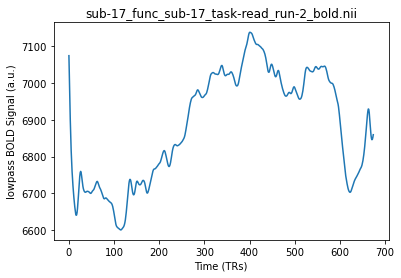

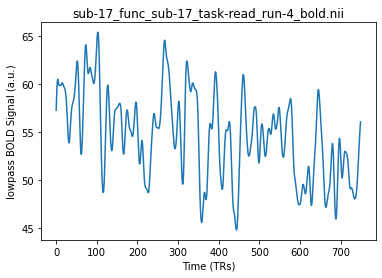

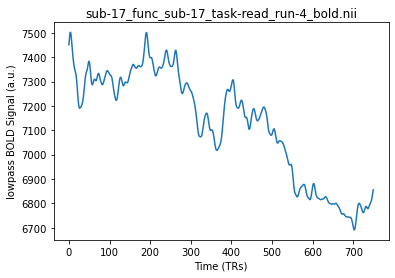

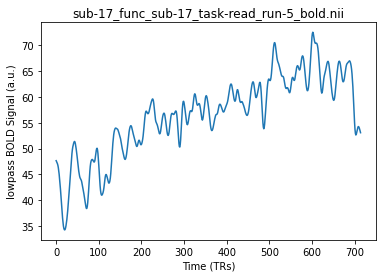

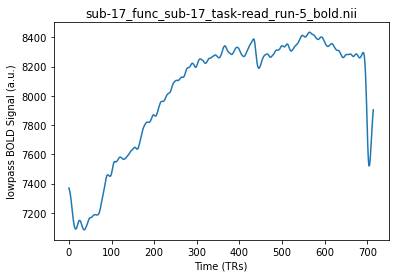

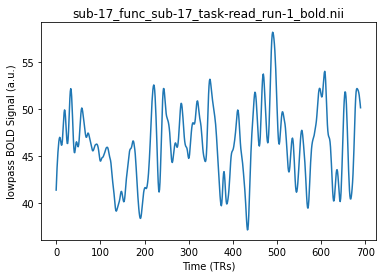

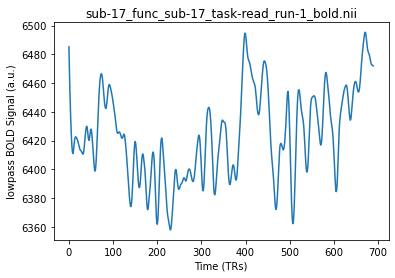

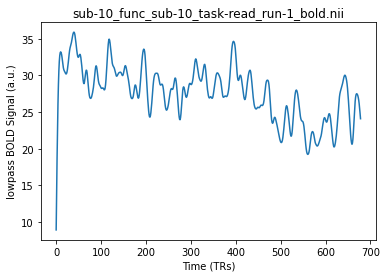

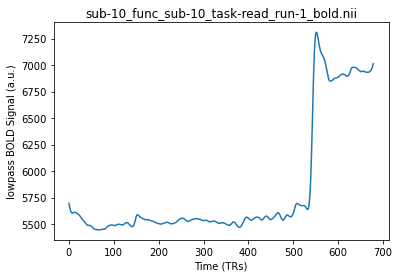

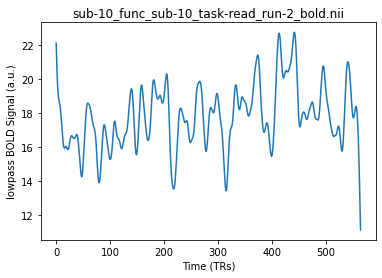

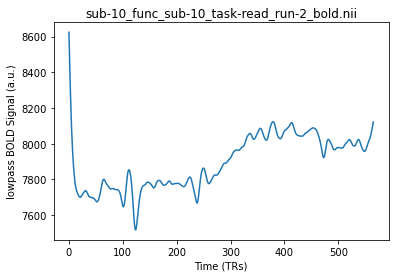

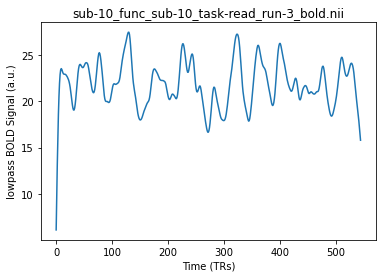

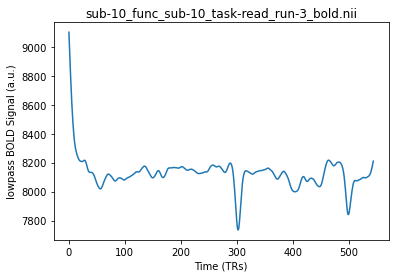

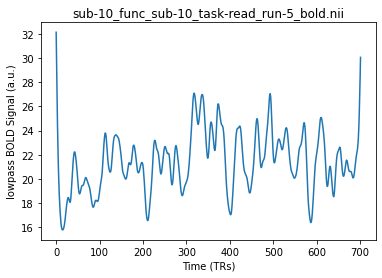

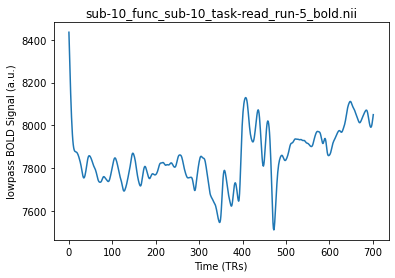

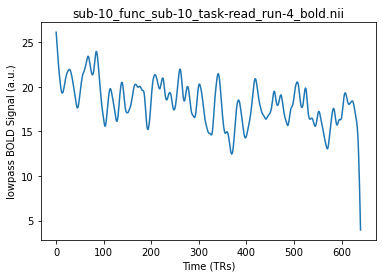

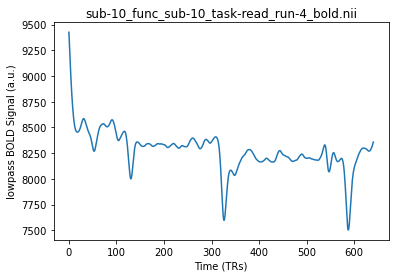

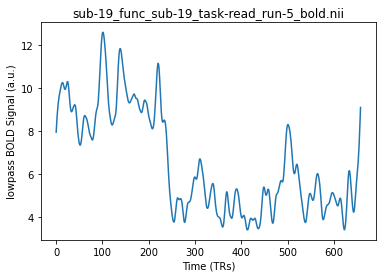

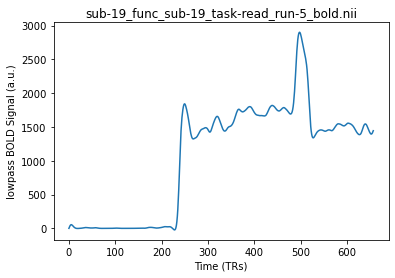

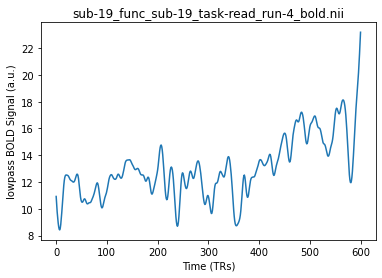

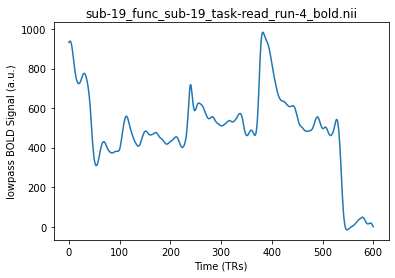

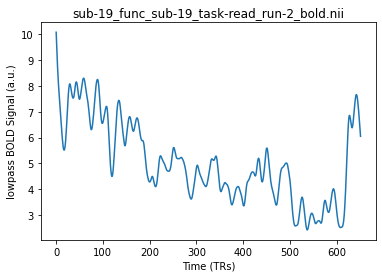

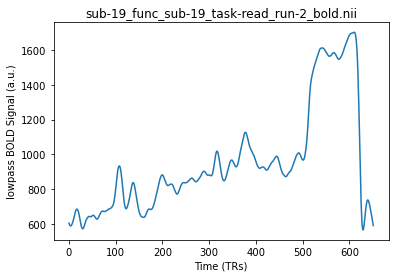

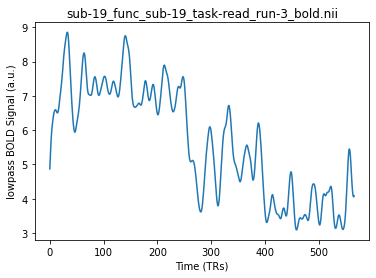

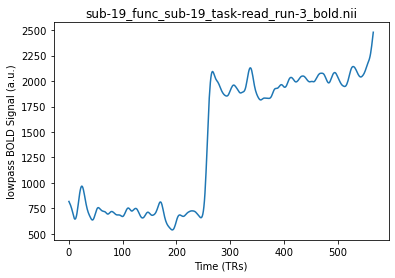

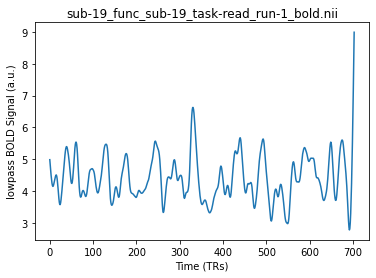

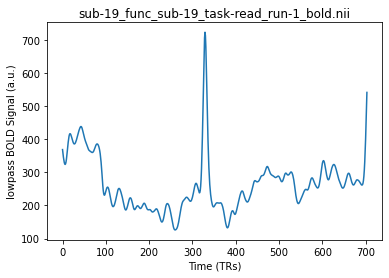

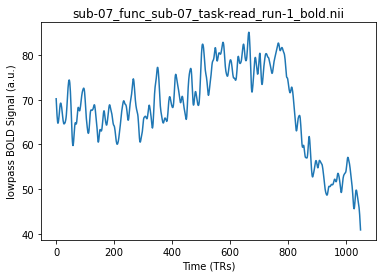

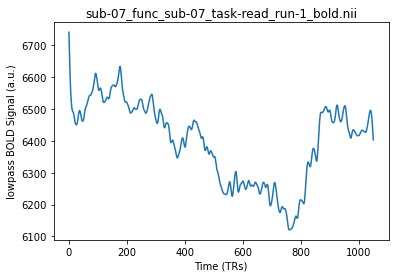

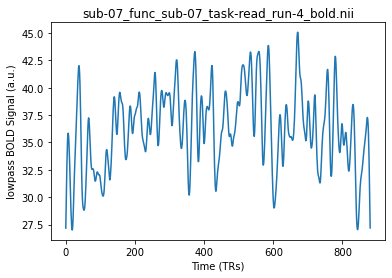

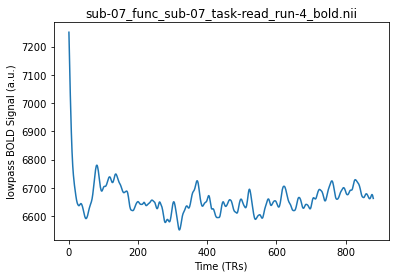

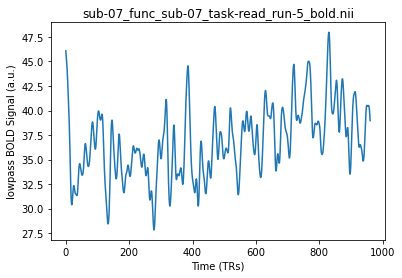

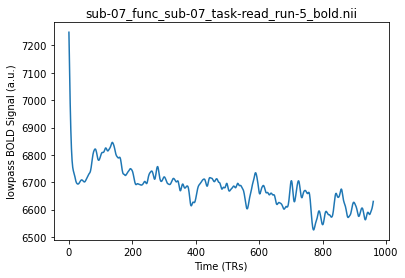

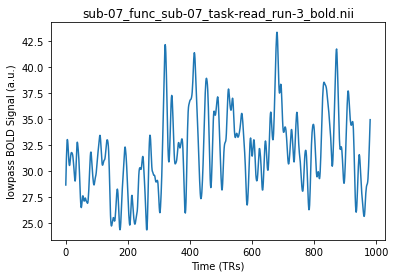

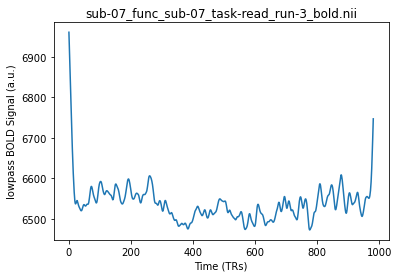

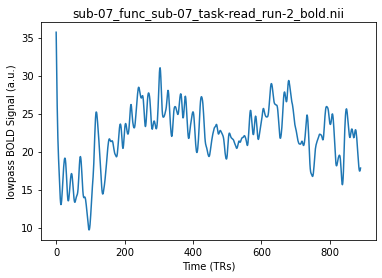

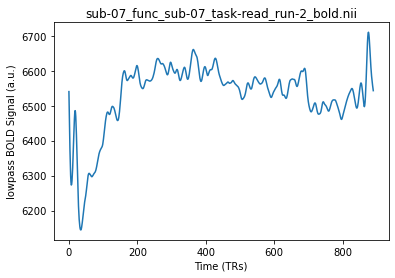

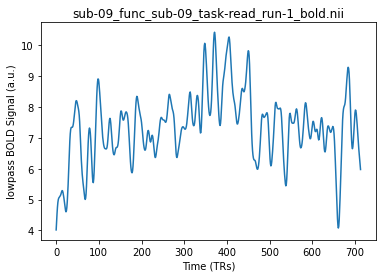

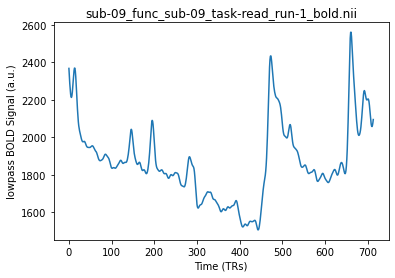

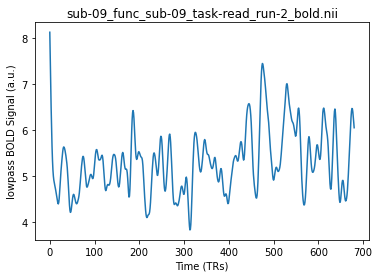

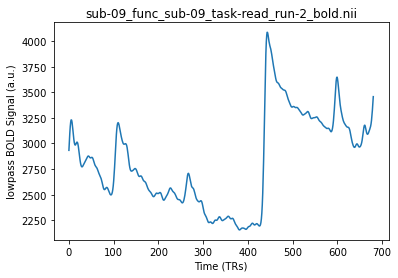

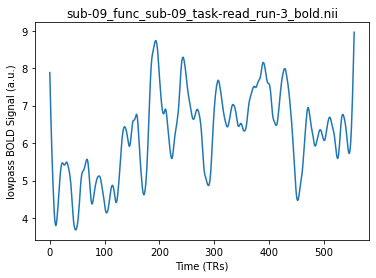

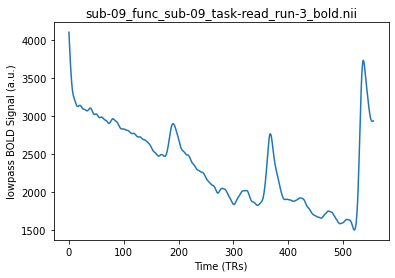

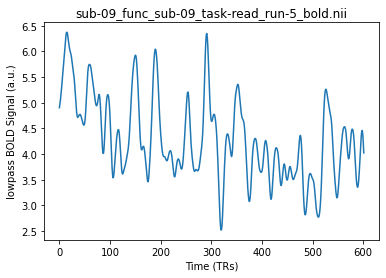

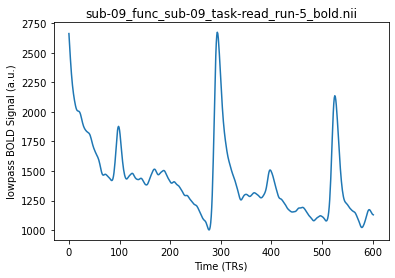

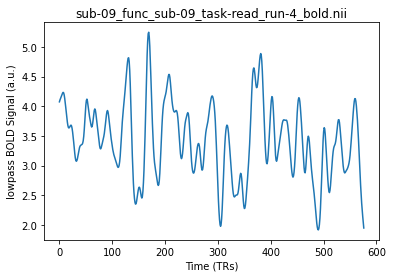

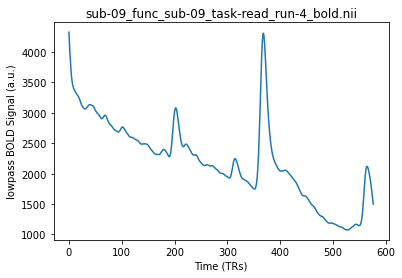

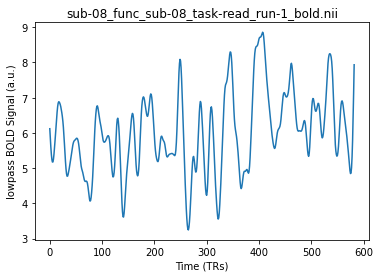

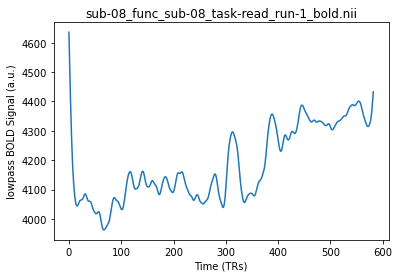

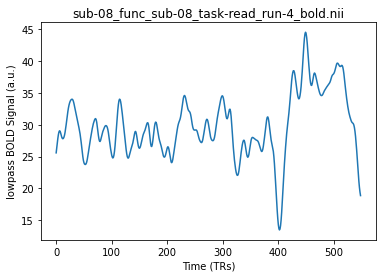

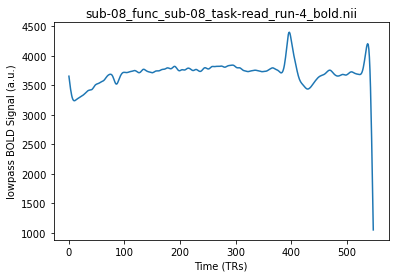

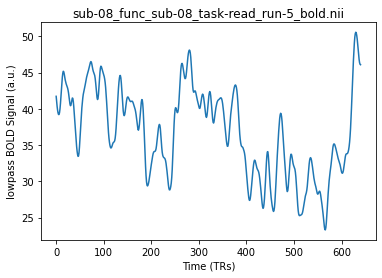

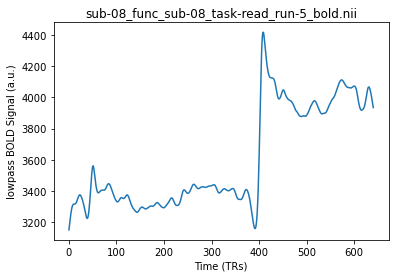

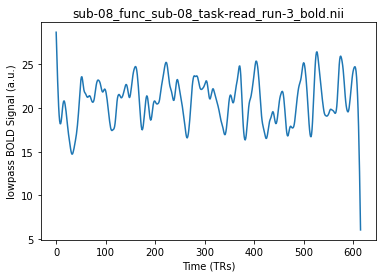

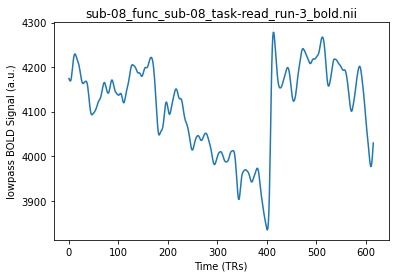

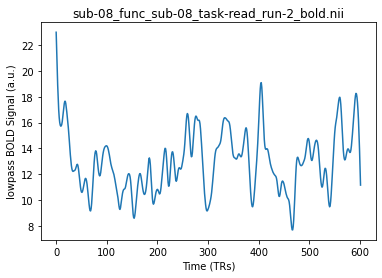

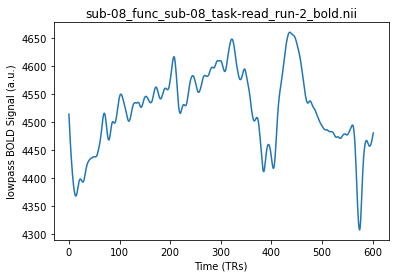

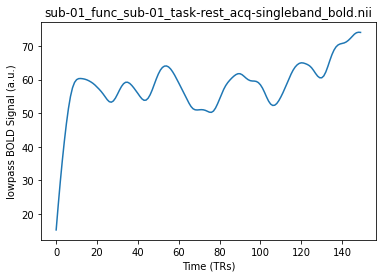

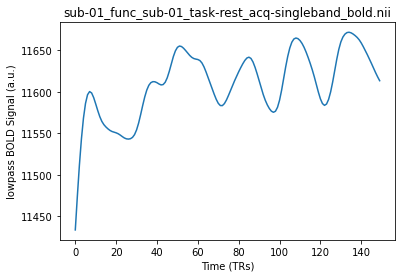

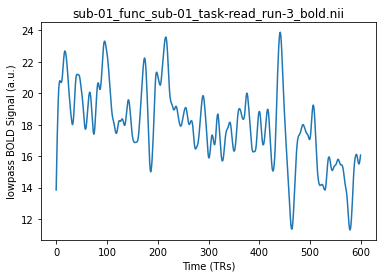

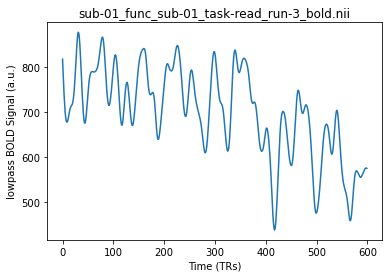

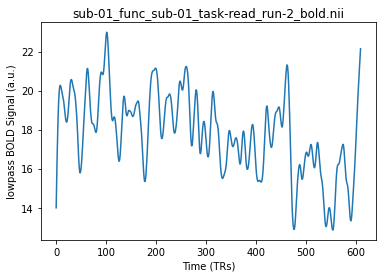

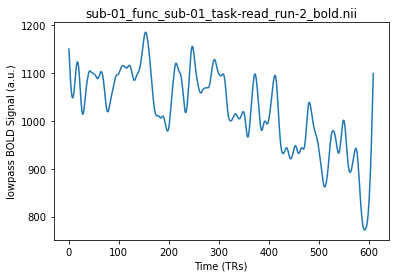

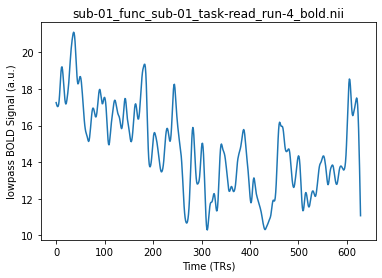

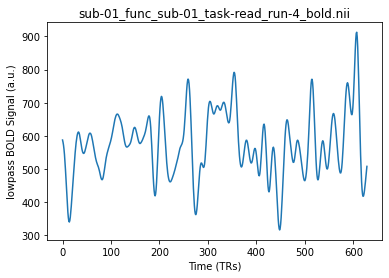

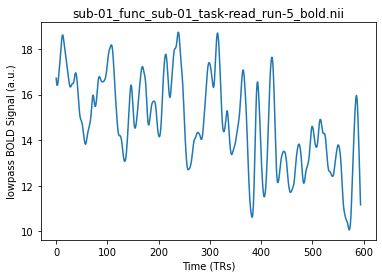

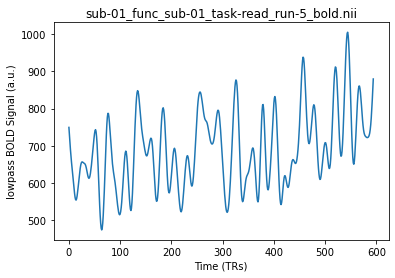

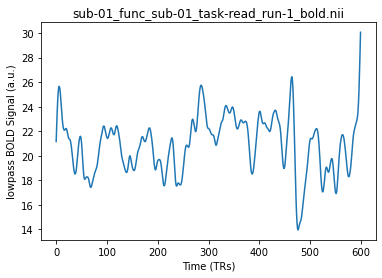

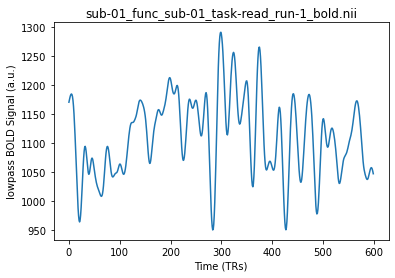

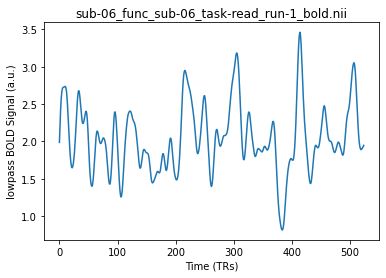

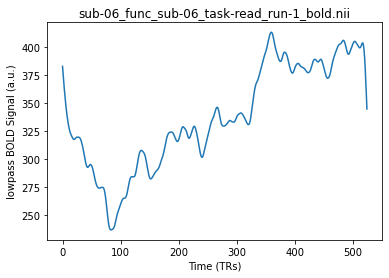

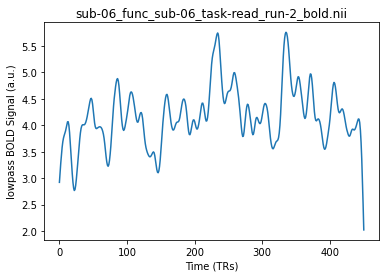

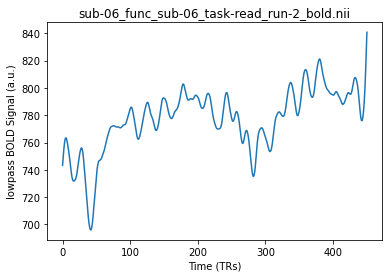

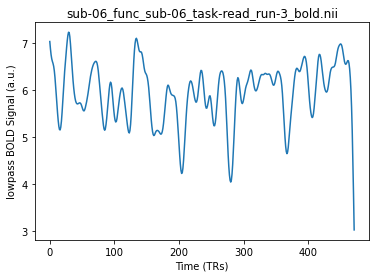

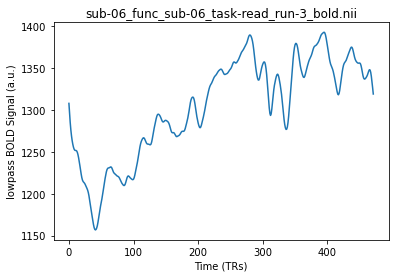

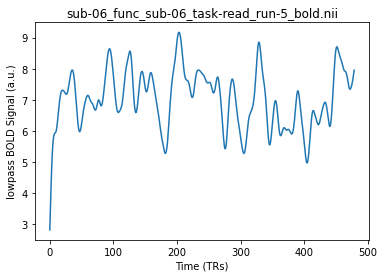

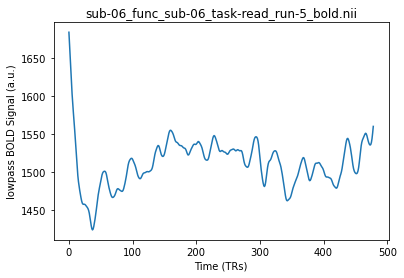

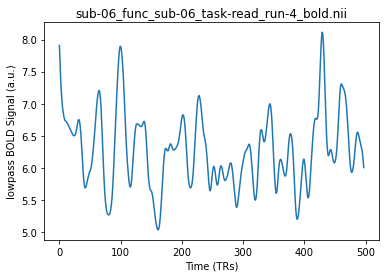

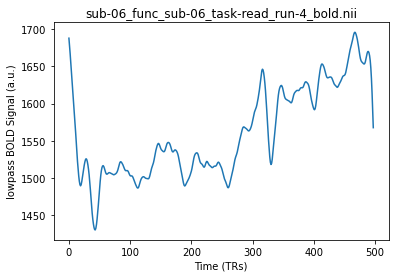

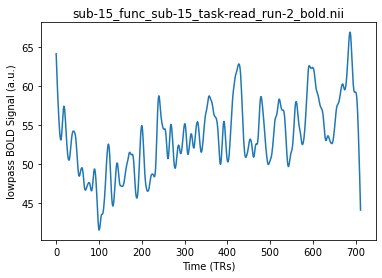

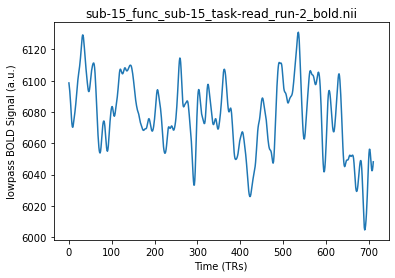

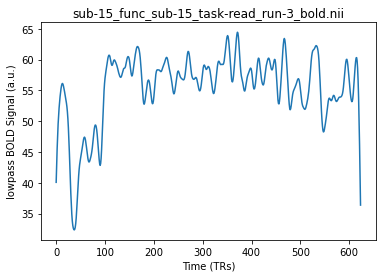

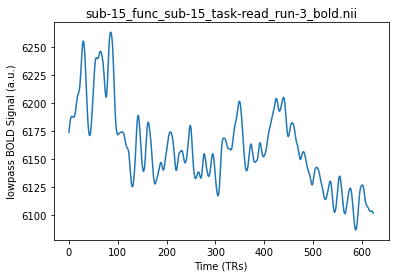

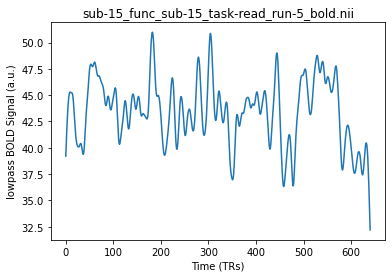

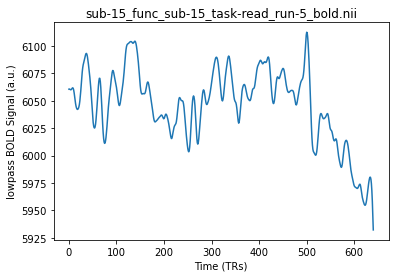

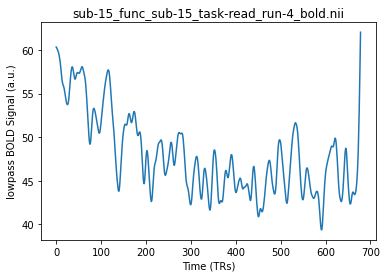

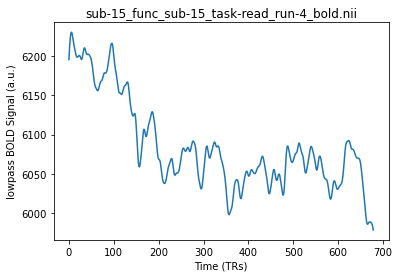

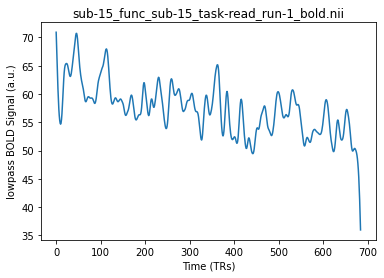

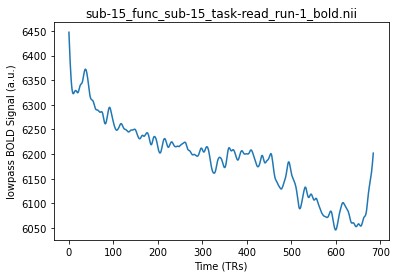

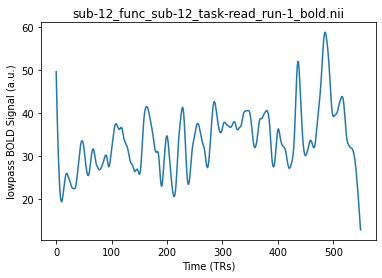

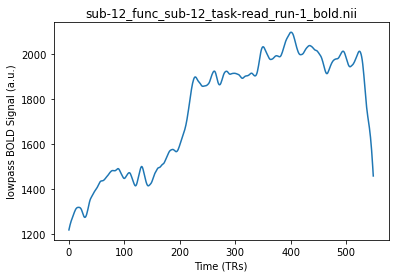

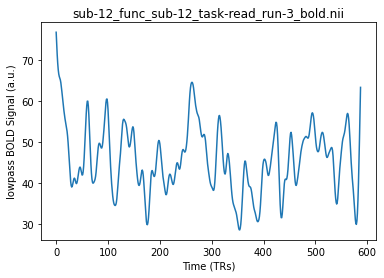

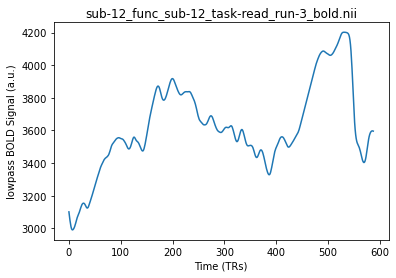

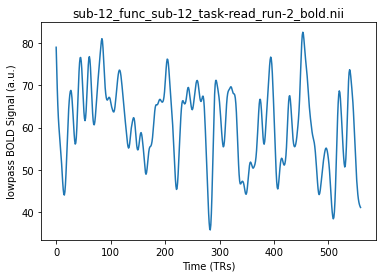

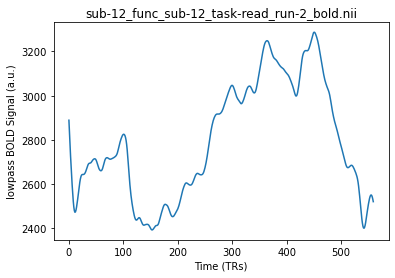

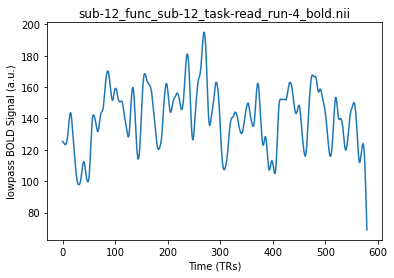

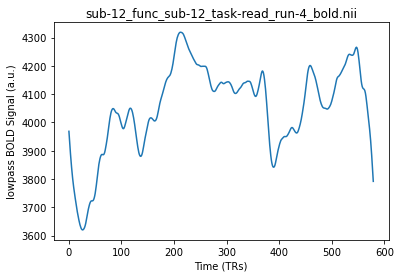

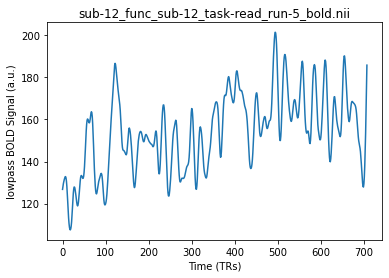

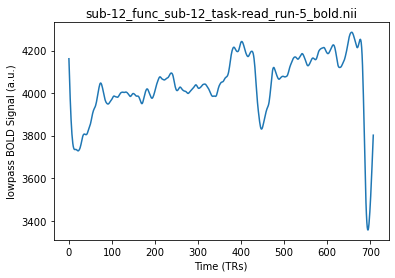

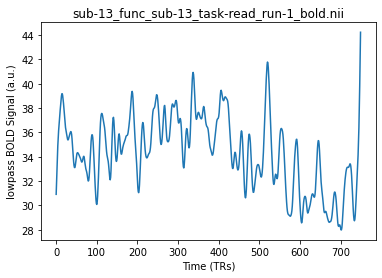

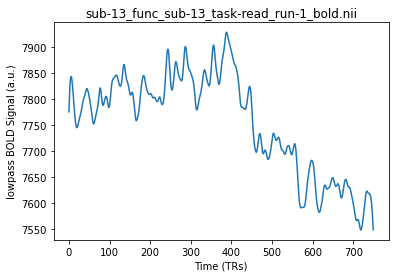

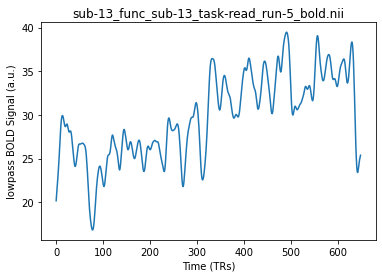

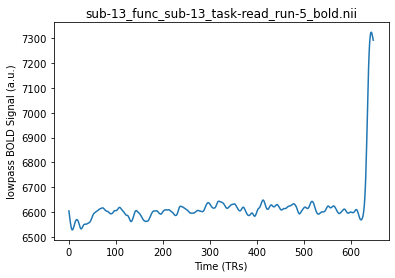

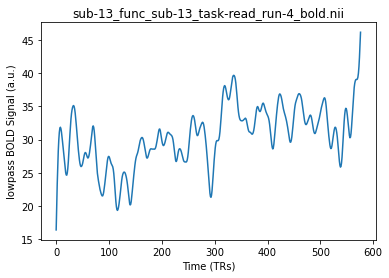

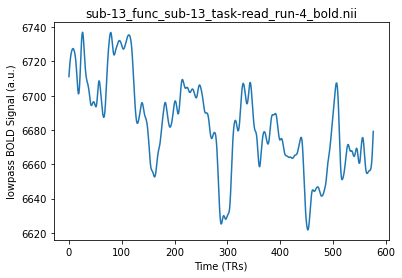

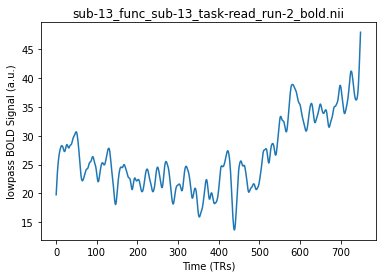

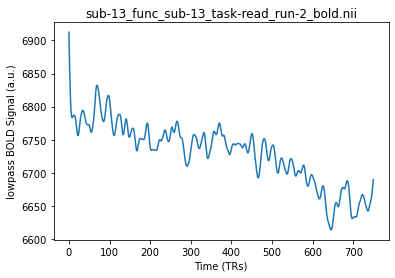

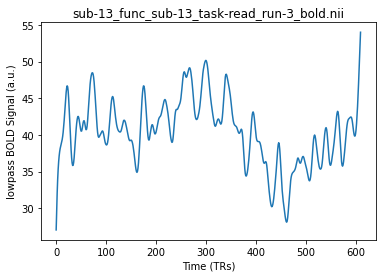

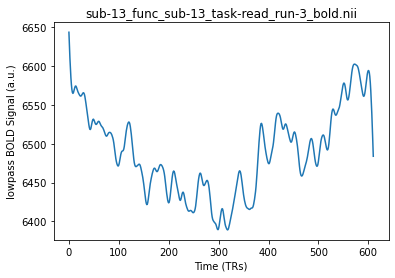

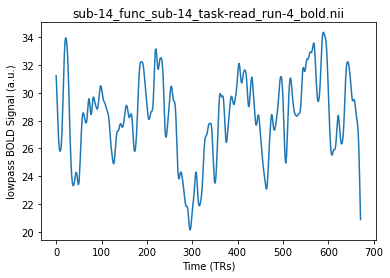

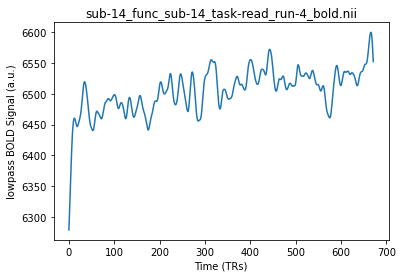

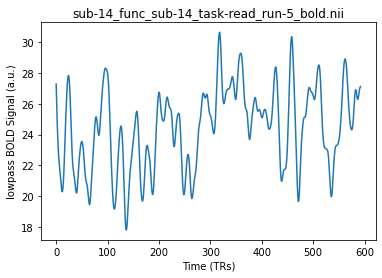

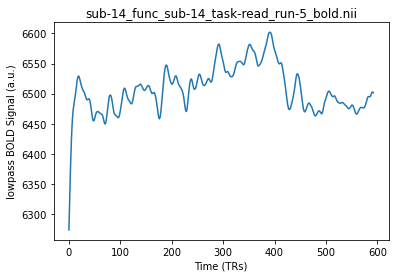

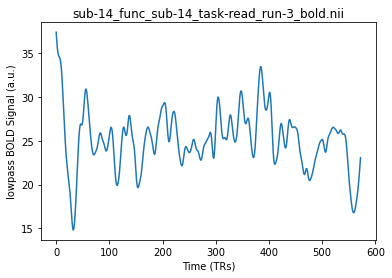

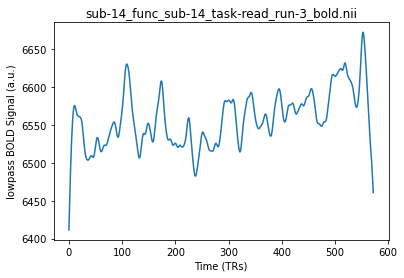

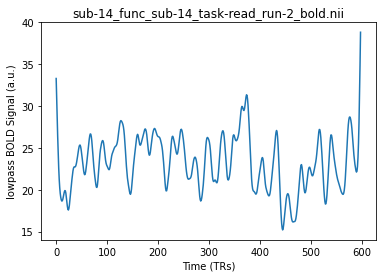

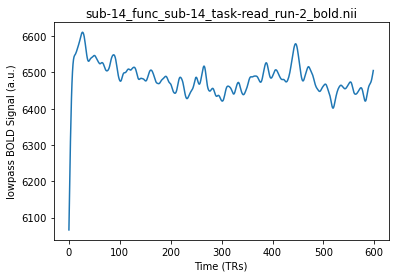

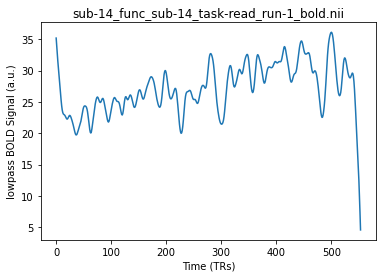

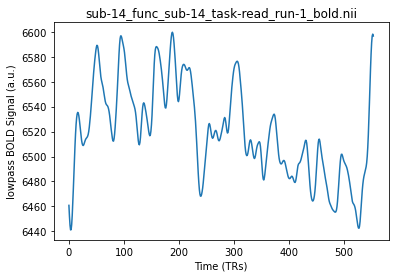

In [12]:
peaks = []
for folder in data_dict:
    folder_name = folder
    folder = data_dict[folder]
    peaks_outer = []
    for name in folder: 
        filtered_data = []
        filtered_data.append(butter_lowpass_filter(folder[name][-1][:, 29, 73, 45], 'nun'))
        filtered_data.append(butter_lowpass_filter(folder[name][-1][:, 29, 34, 45], 'nun'))
        peaks_inner = [[find_peaks(data, height=2), sum(data)/len(data)]  for data in filtered_data]
        count = 0
        for peak in peaks_inner: 
            plt.plot(filtered_data[count])
            plt.title(name)
            plt.xlabel('Time (TRs)')  
            plt.ylabel('lowpass BOLD Signal (a.u.)')
            plt.show()
            plt.close()
            count += 1
        peaks_outer.append(peaks_inner)
    peaks_outer.append(folder_name)
    peaks.append(peaks_outer)

# Data Analysis

Here, we are calculating the average peak amplitude and average number of peaks for each of the two relevant BOLD signals for every participant. 

Each participant participates in 5 trials, so the average peak amplitude and average number of peaks is calculated for each trial. Then, the averages for each trial are averaged to get the overall average peak amplitude and number of peaks for a participant. 

Given this calculation paradigm, each participant will have 2 average peak amplitudes and two average number of peaks, since there are two relevant BOLD signals we are focusing on.

In [13]:
height_list = []
for folder_data in peaks:
    average_height = [] 
    participant_height = [] 
    name = None
    for trial_data in folder_data:
        if type(trial_data) == str: 
            name = trial_data
            continue
        metrics = []
        for peak_data in trial_data:
            peak_data[0][1]['peak_heights'] = [(peak - peak_data[1]) for peak in peak_data[0][1]['peak_heights']]
            height = sum(peak_data[0][1]['peak_heights'])/(len(peak_data[0][1]['peak_heights']))
            metrics.append([height, len(peak_data[0][1]['peak_heights'])])
        average_height.append(metrics)
    for index in range(len(average_height[0])): 
        val = 0
        val2 = 0
        for list1 in average_height: 
            val += list1[index][0]
            val2 += list1[index][1]
        part_height = val/len(average_height)
        num_peaks = val2/len(average_height)
        participant_height.append([index, num_peaks, part_height])
    participant_height.append(name)
    height_list.append(participant_height)
print(height_list)

[[[0, 24.2, 2.633820924677548], [1, 24.0, 23.048047055192363], '/Users/anshverma/Documents/BerkeleyDocs/Neurotech NMEP Project/fMRI func data sub-03'], [[0, 27.8, 1.7145246274374206], [1, 27.6, 23.938236215070372], '/Users/anshverma/Documents/BerkeleyDocs/Neurotech NMEP Project/fMRI func data sub-04'], [[0, 24.8, 1.3436561286010746], [1, 20.0, 70.77264310647054], '/Users/anshverma/Documents/BerkeleyDocs/Neurotech NMEP Project/fMRI func data sub-05'], [[0, 20.8, 1.647963674741904], [1, 19.0, 11.117975596116274], '/Users/anshverma/Documents/BerkeleyDocs/Neurotech NMEP Project/fMRI func data sub-02'], [[0, 25.2, 2.393454918997018], [1, 24.0, 18.170860743482294], '/Users/anshverma/Documents/BerkeleyDocs/Neurotech NMEP Project/fMRI func data sub-20'], [[0, 30.8, 0.9480868842308997], [1, 21.8, 70.98223338340735], '/Users/anshverma/Documents/BerkeleyDocs/Neurotech NMEP Project/fMRI func data sub-18'], [[0, 36.8, 2.291436938889235], [1, 38.6, 12.168989392760144], '/Users/anshverma/Documents/Be

Showing Correlation!

The graphs below demonstrate the correlation between participants' e-score and their bold signal average amplitude/number of peaks. Details about the graphs and how to interpret the graphs can be found when the graphs are presented.

These trends exactly match what the paper reported; we successfully reproduced the results of the paper :)

In [14]:
def agg_vals(lst1, lst2): 
    lst1 = lst1[:]
    lst2 = lst2[:]
    i = 0
    new_lst1 = []
    new_lst2 = []
    while i < len(lst1): 
        j = i + 1
        val = lst1[i]
        tot = [lst2[i]]
        while j < len(lst1): 
            if val == lst1[j]: 
                tot.append(lst2[j])
                lst1.pop(j)
                lst2.pop(j)
            else: 
                j += 1
        new_lst1.append(val)
        tot = sum(tot)/len(tot) 
        new_lst2.append(tot)
        i += 1
    return new_lst1, new_lst2

def display_data(x_axis, y_axis, title):
    plt.title(title) 
    plt.xlabel('e-score')  
    plt.ylabel('average peak amplitude')
    plt.plot(x_axis, y_axis, 'ob') 
    plt.show()
    plt.close()

INFORMATION TO UNDERSTAND GRAPHS

KEY:

title: 'Name of brain region collecting data from - type of data 

types of data: 

individual peak amplitude -> average peak amplitude for each individual participant. 
Several participants had the same e-index score, which is why there are several points 
for some x axis coordinates

aggregate peak amplitude -> average of the average peak amplitude for all individuals that 
have the same e-index score. In clearer terms, I took the average of all the data points 
for one e-score if one e-score corresponded to multiple data points. 
This will help us see the trend of the data clearer.

individual number of peaks -> average number of BOLD peaks each participant had
for their set of trials. Several participants had the same e-index score, which is why 
there are several points for some x axis coordinates

aggregate number of peaks -> average of the average number of peaks for all individuals that have the same e-index score. 
In clearer terms, I to

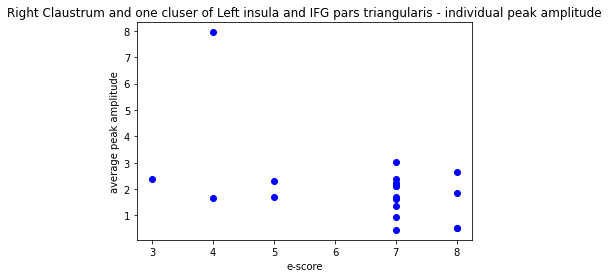

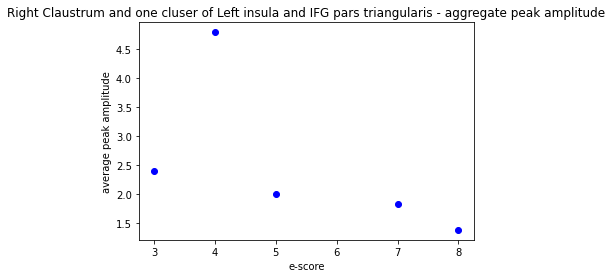

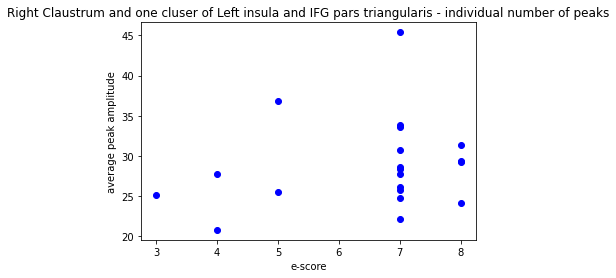

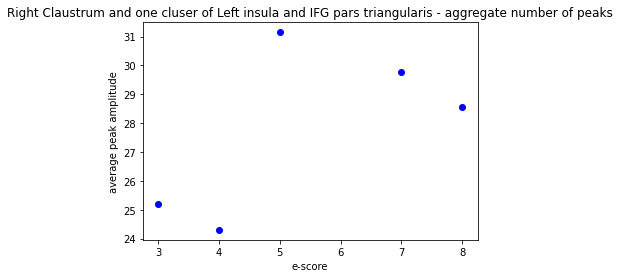

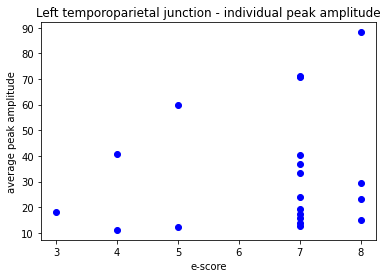

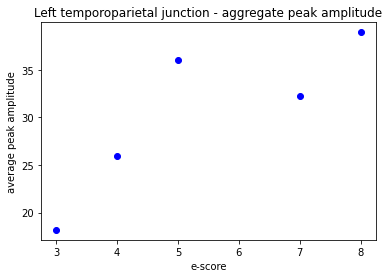

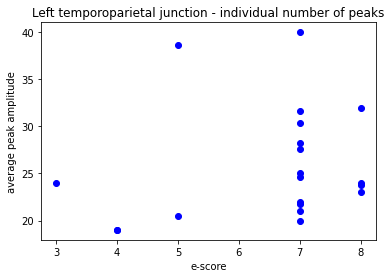

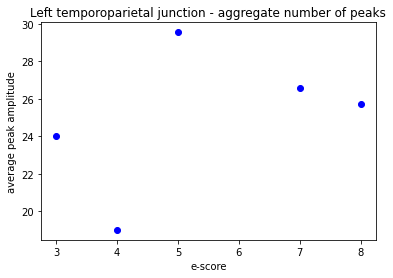

In [15]:
x_axis = []
y_axis = []
for data in height_list: 
    try:
        x_axis.append(escore[int(data[-1][-1])])
    except: 
        x_axis.append(escore[int(data[-1][-2:])])
for data in height_list: 
    if type(val) == str: 
        break
    y_axis.append(data[0][-1])
    
print('INFORMATION TO UNDERSTAND GRAPHS')
print()
print('KEY:')
print()
print("title: 'Name of brain region collecting data from - type of data ")
print()
print("""types of data: 

individual peak amplitude -> average peak amplitude for each individual participant. 
Several participants had the same e-index score, which is why there are several points 
for some x axis coordinates

aggregate peak amplitude -> average of the average peak amplitude for all individuals that 
have the same e-index score. In clearer terms, I took the average of all the data points 
for one e-score if one e-score corresponded to multiple data points. 
This will help us see the trend of the data clearer.

individual number of peaks -> average number of BOLD peaks each participant had
for their set of trials. Several participants had the same e-index score, which is why 
there are several points for some x axis coordinates

aggregate number of peaks -> average of the average number of peaks for all individuals that have the same e-index score. 
In clearer terms, I took the average of all the data points 
for one e-score if one e-score corresponded to multiple data points. 
This will help us see the trend of the data clearer.""")
print()
print("x axis: e-device score index (higher index corresponds to more usage)")
print()
print("""y axis: 
can either be peak amplitude OR number of peaks; thought both would be 
interesting metrics to see a correlation between BOLD activity and e-device usage""")
print()
print("""What we see from....

Right Claustrum and one cluster of Left insula and IFG pars triangularis graphs: 
the trend in the data is negative; this is what the study concluded as well, meaning we 
successfully reproduced this study metric. 


Left temporoparietal junction graphs: 
the trend in this data is positive; this is what the study concluded as well,
meaning we successfully reproduced this study metric

Note -> the reason these trends are true is because we should ONLY be looking at the peak 
amplitude graphs/data when seeing if the trend in this data matches what the paper reported; 
although I thought it would be interesting to look at both peak amplitude and number of peaks, 
according to fMRI literature it seems that only peak amplitude is used to determine 
bold activation (article that states this -> https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5581677/)
""")



title = "Right Claustrum and one cluser of Left insula and IFG pars triangularis - individual peak amplitude"
display_data(x_axis, y_axis, title)
new_x, new_y = agg_vals(x_axis, y_axis)
title = "Right Claustrum and one cluser of Left insula and IFG pars triangularis - aggregate peak amplitude"
display_data(new_x, new_y, title)


y_axis = []
for data in height_list: 
    if type(val) == str: 
        break
    y_axis.append(data[0][-2])
    

title = "Right Claustrum and one cluser of Left insula and IFG pars triangularis - individual number of peaks"
display_data(x_axis, y_axis, title)
new_x, new_y = agg_vals(x_axis, y_axis)
title = "Right Claustrum and one cluser of Left insula and IFG pars triangularis - aggregate number of peaks"
display_data(new_x, new_y, title)



y_axis = []
for data in height_list: 
    if type(val) == str: 
        break
    y_axis.append(data[1][-1])
    
title = "Left temporoparietal junction - individual peak amplitude"
display_data(x_axis, y_axis, title)
title = "Left temporoparietal junction - aggregate peak amplitude"
new_x, new_y = agg_vals(x_axis, y_axis)
display_data(new_x, new_y, title)


y_axis = []
for data in height_list: 
    if type(val) == str: 
        break
    y_axis.append(data[1][-2])

title = "Left temporoparietal junction - individual number of peaks"
display_data(x_axis, y_axis, title)
title = "Left temporoparietal junction - aggregate number of peaks"
new_x, new_y = agg_vals(x_axis, y_axis)
display_data(new_x, new_y, title)